## Implementing method to put ruled rectangles around barrier islands
Test case on Hatteras Island, North Carolina

In [21]:
%matplotlib inline
from pylab import *
from skimage import data, io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math

import netCDF4

from clawpack.visclaw import colormaps, plottools
from clawpack.amrclaw import region_tools
from clawpack.geoclaw import topotools

from skimage.morphology import convex_hull_image, convex_hull_object, label
from skimage.measure import label, regionprops
from skimage.transform import rotate
from skimage import data, img_as_float
from skimage.util import invert
import skimage.io as skio
from skimage.color import rgb2gray

In [2]:
# fetch topography
topo_path = 'clawpack_src/clawpack-v5.7.0/geoclaw/scratch/cape_hatteras_13_mhw_2006.nc'
topo_hat = topotools.read_netcdf(topo_path)
print(topo_hat.extent)

filter_region = (-75.85, -75.3, 35.0, 35.55)
topo = topo_hat.crop(filter_region)
#topo.plot()

(-76.05000000000001, -75.050000000028, 34.75, 35.799999999970595)


In [3]:
#fig, ax = plt.subplots()
#ax.contourf(topo.X, topo.Y, topo.Z, [0,10000], colors = 'k')
#ax.set_axis_off()
#fig.add_axes(ax)
#plt.gca().set_aspect(1.0 / cos(pi / 180.0 * topo.y.mean()))
#plt.savefig('hatteras_image.jpg', bbox_inches='tight', pad_inches=0)

## Convex Hull

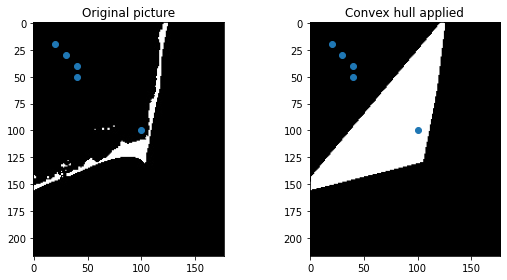

(217, 177)
False


In [4]:
im_src = skio.imread('hatteras_image.jpg')
image = rgb2gray(im_src)

image = invert(image)
#chull = convex_hull_object(image) # convex hull of individual objects using label function
chull = convex_hull_image(image)

'''
# apply threshold
#thresh = threshold_otsu(chull)
bw = closing(chull)

# remove artifacts connected to image border
cleared = clear_border(bw)

# label image regions
label_image = label(cleared)
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=image, bg_label=0)
'''

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].set_title('Original picture')
ax[0].imshow(image, cmap=plt.cm.gray)
#ax[0].set_axis_off()

x = [20, 30, 40, 40, 100]
y = [20, 30, 40, 50, 100]
ax[0].scatter(x, y)

ax[1].set_title('Convex hull applied')
ax[1].imshow(chull, cmap=plt.cm.gray)
#ax[1].set_axis_off()
ax[1].scatter(x,y)

plt.tight_layout()
plt.show()

print(np.shape(chull))
print(chull[100,150])

In [5]:
# function to find first and last occurence of a value in an array
# returns -1 if value not found
def find_first_and_last(array, x):
   
    # initialize result with -1
    first = -1
    last = -1
    
    for i in range(0, len(array)):
        if(array[i] != x):
            continue
        if(first == -1):
            first = i
        last = i
        
    return first, last        


# function to find array coordinates of median line through image as ndarray
def find_median_line(image):
    # transpose image array
    imageT = np.transpose(image)
    #print(np.shape(imageT))

    # create array of indices of median points
    median_pts = []
    row_num = 0
    for row in imageT:
        first, last = find_first_and_last(row, True)
        #print(first, last)
        if(first != -1):
            if((first + last) %2 == 0):
                median_index = int((first + last) / 2)
            else:
                median_index = int((first + last + 1) / 2)
        
            #print(median_index)
            median_pts.append((row_num, median_index))

        row_num += 1
        
    return median_pts

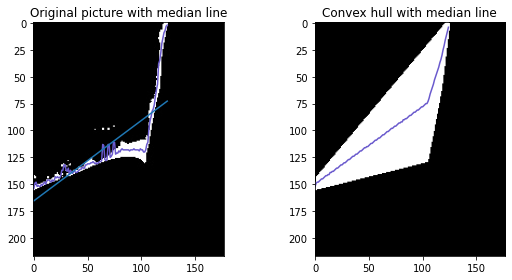

In [6]:
x, y = zip(*find_median_line(image))

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].set_title('Original picture with median line')
ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].plot(x, y, 'slateblue')
ax[0].plot(x, np.poly1d(np.polyfit(x, y, 1))(x)) # best fit line evaluated at x

cx, cy = zip(*find_median_line(chull))

ax[1].set_title('Convex hull with median line')
ax[1].imshow(chull, cmap=plt.cm.gray)
ax[1].plot(cx, cy, 'slateblue')

plt.tight_layout()
plt.show()

[100]


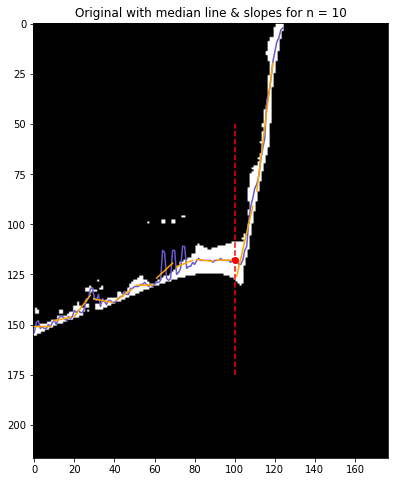

In [7]:
# find slope of best fit line on median through n points at a time

x, y = zip(*find_median_line(image))
cx, cy = zip(*find_median_line(chull))

# set up plot
fig, ax = plt.subplots(figsize=(10, 8))
#ax = axes.ravel()
ax.set_title('Original with median line & slopes for n = 10')
ax.imshow(image, cmap=plt.cm.gray)
ax.plot(x, y, 'slateblue')

'''ax[1].set_title('Convex hull with median line & slopes')
ax[1].imshow(chull, cmap=plt.cm.gray)
ax[1].plot(cx, cy, 'slateblue')'''

n = 10 
med_line = find_median_line(image)
#x, y = zip(*median_line)

i = 0
m_prev = 0 # INITIALIZE THIS AS SOMETHING DIFFERENT (slope between first 2 points?)
cut_pts = []

while i < (len(med_line) - n):
    #x_0 = med_line[i][0]
    #y_0 = med_line[i][1]
    
    #x_n = med_line[i+n-1][0]
    #y_n = med_line[i+n-1][1]
    
    selected_pts = med_line[i:i+n-1]
    x, y = zip(*selected_pts)
    
    # find best fit line
    y_fit = np.poly1d(np.polyfit(x, y, 1))(x)
    # calculate slope
    m = (y_fit[-1] - y_fit[0]) / (x[-1] - x[0])
    
    ax.plot(x, y_fit, 'orange')

    #print(np.abs(m_prev-m), i)
    m_diff = np.abs(m_prev - m)
    if(m_diff >= 4): # MAYBE USE RATIO INSTEAD OF CONSTANT
        cut_pts.append(i)
        ax.plot(i, med_line[i][1], 'ro')
        ax.plot([i, i], [175, 50], 'r--')
                
    m_prev = m        
    
    i += n


print(cut_pts)
#print(median_line[:10])
#x, y = zip(*median_line[:10])
#print(x, y)
#print(np.poly1d(np.polyfit(x, y, 1))(x)[-1])

In [8]:
# function to find cut points based on slope of median line through n points at a time

def cut_points(median_line, n):
    
    i = 0
    m_prev = 0 # INITIALIZE THIS AS SOMETHING DIFFERENT (slope between first 2 points?)
    # OR JUST DO NOTHING IN FUNCTION IF i=0
    cut_points = []

    while i < (len(median_line) - n):        
        
        # select the next n points
        selected_pts = median_line[i:i+n-1]
        x, y = zip(*selected_pts)

        # best fit line through the selected points evaluated at x
        y_fit = np.poly1d(np.polyfit(x, y, 1))(x)
        
        # calculate slope
        m = (y_fit[-1] - y_fit[0]) / (x[-1] - x[0])

        m_diff = np.abs(m_prev - m)
        
        # add a cut point if difference between slopes is ... 
        if(m_diff >= 4): # MAYBE USE RATIO OR PERCENT CHANGE INSTEAD
            cut_points.append((i, median_line[i][1]))

        m_prev = m 
        
        i += n
        
    return cut_points

In [9]:
print(cut_points(find_median_line(image),10))

[(100, 118)]


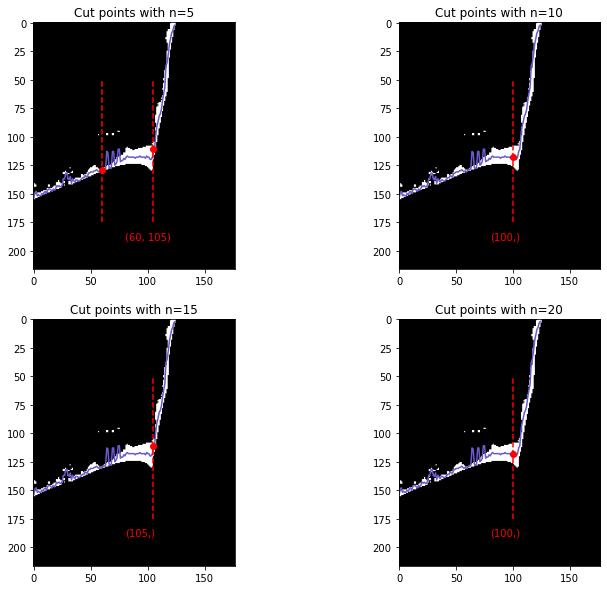

In [10]:
med_line = find_median_line(image)

x, y = zip(*find_median_line(image))
#cx, cy = zip(*find_median_line(chull))

'''n = 10
cut_x, cut_y = zip(*cut_points(med_line, n))
print(cut_x, cut_y)'''

'''# set up plot
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()
ax[0].set_title('Original with median line & cut point')
ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].plot(x, y, 'slateblue')
ax[0].plot(cut_x, cut_y, 'ro')
ax[0].plot([cut_x, cut_x], [175, 50], 'r--')

ax[1].set_title('Convex hull with median line & cut point')
ax[1].imshow(chull, cmap=plt.cm.gray)
ax[1].plot(cx, cy, 'slateblue')'''

fig, ax = plt.subplots(2, 2, figsize=(12,10))
ax = ax.ravel()

i = 0
for n in range(5, 25, 5):
    cut_x, cut_y = zip(*cut_points(med_line, n))    
    
    ax[i].set_title('Cut points with n={}'.format(n))
    ax[i].imshow(image, cmap=plt.cm.gray)
    ax[i].plot(x, y, 'slateblue')
    ax[i].plot(cut_x, cut_y, 'ro')
    ax[i].plot([cut_x, cut_x], [175, 50], 'r--')
    ax[i].annotate('{}'.format(cut_x), xy=(75, 180), xytext=(80, 190), color = 'red')
    
    i += 1

# NOTE: function produces multiple cut points for n < 7
# and doesn't produce cut points for n > 20

In [11]:
# draw separate convex hulls using cut points with n=10

image2 = np.copy(image) # make copy of original image array

print(np.shape(image))
print(np.shape(image2))

n = 10
cut_point = cut_points(find_median_line(image2), n)
# extract x coordinate (corresponds to column of array)
cut_col = cut_point[0][0]

image2[:,cut_col:] = np.where(image2[:,cut_col:] > 0, 2, image2[:,cut_col:])

#print(image2[100:103])
print(np.shape(image2))

#image2_labled = label(image2, connectivity=1)

chull2 = convex_hull_object(image2, connectivity=2) #SEE WHAT 1 DOES

(217, 177)
(217, 177)
(217, 177)


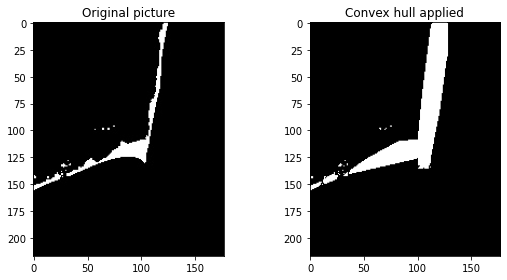

In [12]:
# plot results
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].set_title('Original picture')
ax[0].imshow(image, cmap=plt.cm.gray)
#ax[0].set_axis_off()

ax[1].set_title('Convex hull applied')
ax[1].imshow(chull2, cmap=plt.cm.gray)
#ax[1].set_axis_off()

plt.tight_layout()
plt.show()

In [13]:
# scratch
x = np.eye(3).astype(int)
print(x)

print(x[:,1:])

x[:,2:] = np.where(x[:,2:] > 0, 2, x[:,2:])

print(x)

x[1, 1] = 0.5
print(x)

[[1 0 0]
 [0 1 0]
 [0 0 1]]
[[0 0]
 [1 0]
 [0 1]]
[[1 0 0]
 [0 1 0]
 [0 0 2]]
[[1 0 0]
 [0 0 0]
 [0 0 2]]


## Rectangles using min/max algorithm

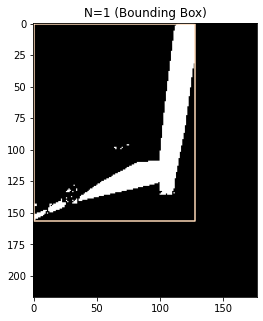

0 0 156 128
19968


In [14]:
regions = regionprops(chull2.astype(int))

fig, ax = plt.subplots(figsize=(4, 6))
ax.imshow(chull2, cmap=plt.cm.gray)
ax.set_title('N=1 (Bounding Box)')

for region in regions:
    # min/max row/column for bounding box
    minr, minc, maxr, maxc = region.bbox
    
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, 'peachpuff', linewidth=1.5)

plt.show()
print(minr, minc, maxr, maxc)
print((maxc - minc) * (maxr - minr))

NameError: name 'max_min' is not defined

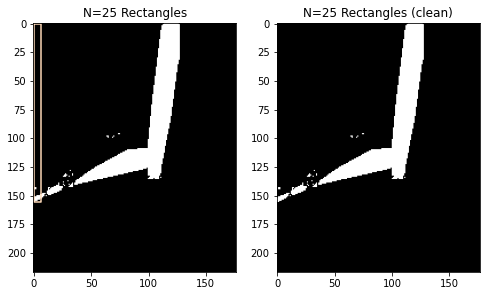

In [15]:
# number of rectangles
N = 25

#diff_r = maxr - minr
diff_c = maxc - minc

c_step = diff_c / N 

#corners = np.linspace(minc + c_step, maxc, N, endpoint=True) #right corners

fig, ax = plt.subplots(1, 2, figsize=(8, 6))
ax[0].imshow(chull2, cmap=plt.cm.gray)
ax[0].set_title('N={} Rectangles'.format(N))
ax[1].imshow(chull2, cmap=plt.cm.gray)
ax[1].set_title('N={} Rectangles (clean)'.format(N))

#bx = (minc, minc + c_step, minc + c_step, minc, minc)
#by = (minr, minr, maxr, maxr, minr)
#ax.plot(bx, by, 'skyblue', linewidth=1.5)

total_area = 0

for i in range(0, N): 
    leftc = math.ceil(minc + i*c_step)
    rightc = min(math.ceil(minc + (i+1)*c_step), maxc)
    bx = (leftc, rightc, rightc, leftc, leftc)
    by = (minr, minr, maxr, maxr, minr)
    ax[0].plot(bx, by, 'peachpuff', linewidth=1.5)
    #print(leftc, rightc)
    
    maxc_index, maxr_index, minc_index, minr_index = max_min(chull2[minr:maxr, leftc:rightc], True)
    #top_coord = (maxc_index, maxr_index)
    #bottom_coord = (minc_index, minr_index)
    #print(top_coord, bottom_coord)
    ax[0].plot(leftc + maxc_index, maxr_index, 'mo')
    ax[0].plot(leftc + minc_index, minr_index, 'yo')
    #ax[1].plot(leftc + maxc_index, maxr_index, 'mo')
    #ax[1].plot(leftc + minc_index, minr_index, 'yo')
    
    by_shrunk = (minr_index, minr_index, maxr_index, maxr_index, minr_index)
    ax[0].plot(bx, by_shrunk, 'skyblue', linewidth=1.5)
    ax[1].plot(bx, by_shrunk, 'skyblue', linewidth=1.5)
    
    # find area of rectangle
    area = (rightc - leftc) * (minr_index - maxr_index)
    #print(rightc, leftc, maxr_index, minr_index)
    total_area += area
    
    # count number of non-island pixels (where array is False)
    water_pixels = np.count_nonzero(chull2[minr_index:maxr_index, leftc:rightc] == False)
    # ^^ NOT WORKING 


print("Total area: {}".format(total_area))
 

In [ ]:
regions = regionprops(image.astype(int))

for region in regions:
    # min/max row/column for bounding box
    minr, minc, maxr, maxc = region.bbox
    
N = 20

diff_c = maxc - minc

c_step = diff_c / N 

fig, ax = plt.subplots(1, 2, figsize=(8, 6))
ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original Image N={} Rectangles'.format(N))
ax[1].imshow(image, cmap=plt.cm.gray)
ax[1].set_title('Original Image N={} Rectangles (clean)'.format(N))

total_area = 0

for i in range(0, N): 
    leftc = math.ceil(minc + i*c_step)
    rightc = min(math.ceil(minc + (i+1)*c_step), maxc)
    bx = (leftc, rightc, rightc, leftc, leftc)
    by = (minr, minr, maxr, maxr, minr)
    ax[0].plot(bx, by, 'peachpuff', linewidth=1.5)
    #print(leftc, rightc)
    
    maxc_index, maxr_index, minc_index, minr_index = max_min(image[minr:maxr, leftc:rightc], True)
    #top_coord = (maxc_index, maxr_index)
    #bottom_coord = (minc_index, minr_index)
    #print(top_coord, bottom_coord)
    ax[0].plot(leftc + maxc_index, maxr_index, 'mo')
    ax[0].plot(leftc + minc_index, minr_index, 'yo')
    #ax[1].plot(leftc + maxc_index, maxr_index, 'mo')
    #ax[1].plot(leftc + minc_index, minr_index, 'yo')
    
    by_shrunk = (minr_index, minr_index, maxr_index, maxr_index, minr_index)
    ax[0].plot(bx, by_shrunk, 'skyblue', linewidth=1.5)
    ax[1].plot(bx, by_shrunk, 'skyblue', linewidth=1.5)
    
    area = (rightc - leftc) * (minr_index - maxr_index)
    total_area += area


print("Total area: {}".format(total_area))  

In [ ]:
# function to find max and min row of value occurance
def max_min(image, x):
    # transpose image array
    imageT = np.transpose(image)
    #print(np.shape(imageT))

    # create array of indices of median points
    firsts = []
    lasts = []
    row_num = 0
    for row in imageT:
        first, last = find_first_and_last(row, x)
        #print(first, last)
        firsts.append(first)
        lasts.append(last)
        
        # min/max of indices not equal to -1
        if(first == min([a for a in firsts if a != -1])):
            maxc_index = row_num
            maxr_index = first
        if(last == max([a for a in lasts if a != -1])):
            minc_index = row_num
            minr_index = last

        row_num += 1
    
    #max_index = min(firsts)
    #min_index = max(lasts)
    
    return maxc_index, maxr_index, minc_index, minr_index

In [ ]:
# compare total area of convex hull vs. original as N increases

for N in range(1, 20):
    
    chull2_regions = regionprops(chull2.astype(int))
    for region in chull2_regions:
    # min/max row/column for bounding box
        cminr, cminc, cmaxr, cmaxc = region.bbox
    im_regions = regionprops(image.astype(int))
    for region in im_regions:
    # min/max row/column for bounding box
        iminr, iminc, imaxr, imaxc = region.bbox
        
    cdiff_c = cmaxc - cminc
    cc_step = cdiff_c / N 
    
    idiff_c = imaxc - iminc
    ic_step = idiff_c / N
    
    ctotal_area = 0
    itotal_area = 0
    
    for i in range(0, N): 
        # convex hull
        cleftc = math.ceil(cminc + i*cc_step)
        crightc = min(math.ceil(cminc + (i+1)*cc_step), cmaxc)
        cbx = (cleftc, crightc, crightc, cleftc, cleftc)
        cby = (cminr, cminr, cmaxr, cmaxr, cminr)
    
        cmaxc_index, cmaxr_index, cminc_index, cminr_index = max_min(chull2[cminr:cmaxr, cleftc:crightc], True)
    
        cby_shrunk = (cminr_index, cminr_index, cmaxr_index, cmaxr_index, cminr_index)    
        # find area of rectangle
        carea = (crightc - cleftc) * (cminr_index - cmaxr_index)
        ctotal_area += carea
    
        # original image
        ileftc = math.ceil(iminc + i*ic_step)
        irightc = min(math.ceil(iminc + (i+1)*ic_step), imaxc)
        ibx = (ileftc, irightc, irightc, ileftc, ileftc)
        iby = (iminr, iminr, imaxr, imaxr, iminr)

        imaxc_index, imaxr_index, iminc_index, iminr_index = max_min(image[iminr:imaxr, ileftc:irightc], True)

        iby_shrunk = (iminr_index, iminr_index, imaxr_index, imaxr_index, iminr_index)

        iarea = (irightc - ileftc) * (iminr_index - imaxr_index)
        itotal_area += iarea

In [ ]:
#print(x[0:2, 1:3])
#print(x)

#print(max_min(x, 2))

a = np.array([[True, True, False, False, True], [False, False, False, False, True]])
#print(min([a for a in arr if a != -1]))
print(np.count_nonzero(a == 1, axis=0))

chull2_crop = chull2[125:135, 100:105]
print(chull2_crop)
print(np.count_nonzero(chull2_crop == True))

b = [(1, 2, 3), (4, 5, 6,)]


## Rectangles using bounding box (better!!)

Total area for 20 rectangles: 4582
Total water area: 1226
Total land area: 3356
Percent land area: 0.7324


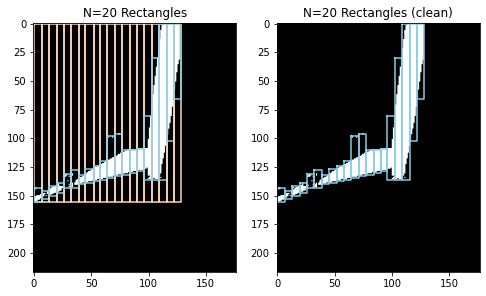

In [16]:
# bounding box for entire convex hull
regions = regionprops(chull2.astype(int))

for region in regions:
    # min/max row/column for bounding box
    minr, minc, maxr, maxc = region.bbox


# number of rectangles
N = 20

#diff_r = maxr - minr
diff_c = maxc - minc

c_step = diff_c / N 

fig, ax = plt.subplots(1, 2, figsize=(8, 6))
ax[0].imshow(chull2, cmap=plt.cm.gray)
ax[0].set_title('N={} Rectangles'.format(N))
ax[1].imshow(chull2, cmap=plt.cm.gray)
ax[1].set_title('N={} Rectangles (clean)'.format(N))

total_area = 0
total_water = 0

for i in range(0, N): 
    leftc = math.ceil(minc + i*c_step)
    rightc = min(math.ceil(minc + (i+1)*c_step), maxc)
    bx = (leftc, rightc, rightc, leftc, leftc)
    by = (minr, minr, maxr, maxr, minr)
    ax[0].plot(bx, by, 'peachpuff', linewidth=1.5)
    #print(leftc, rightc)

    # find bounding box for each rectangle region
    rect_region = regionprops(chull2[:, leftc:rightc].astype(int))

    for region in rect_region:
        # min/max row/column for bounding box
        rect_minr, rect_minc, rect_maxr, rect_maxc = region.bbox
        # number of pixels in bounding box
        area = region.bbox_area
    
        rect_bx = (rect_minc, rect_maxc, rect_maxc, rect_minc, rect_minc)
        rect_bx_plus_left = tuple(x+leftc for x in rect_bx)
        rect_by = (rect_minr, rect_minr, rect_maxr, rect_maxr, rect_minr)
        
    ax[0].plot(rect_bx_plus_left, rect_by, 'skyblue', linewidth=1.5)
    ax[1].plot(rect_bx_plus_left, rect_by, 'skyblue', linewidth=1.5)
    
    total_area += area
    #print(rect_bx_plus_left, area, total_area)
    
    # count number of non-island pixels (where array is False)
    chull2_cropped = chull2[rect_minr:rect_maxr, leftc + rect_minc:leftc + rect_maxc]
    water = np.count_nonzero(chull2_cropped == False)
    
    total_water += water
    #print(area, water, total_water)
    
    #print(leftc+rect_maxc)
    
    
print("Total area for {} rectangles: {}".format(N, total_area))
print("Total water area: {}".format(total_water))
print("Total land area: {}".format(total_area - total_water))
print("Percent land area: {}".format(round((total_area - total_water) / total_area, 4)))

Total area for 20 rectangles: 4989
Total water area: 1633
Total land area: 3356
Percent land area: 0.6727


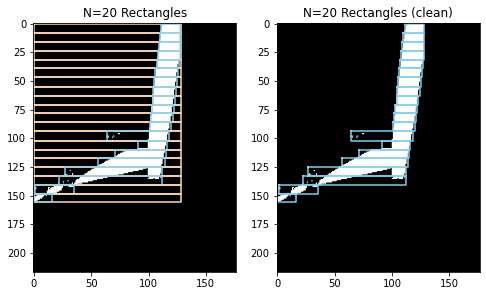

In [17]:
# bounding box for entire convex hull
regions = regionprops(chull2.astype(int))

for region in regions:
    # min/max row/column for bounding box
    minr, minc, maxr, maxc = region.bbox


# number of rectangles
N = 20

diff_r = maxr - minr
#diff_c = maxc - minc

r_step = diff_r / N 

fig, ax = plt.subplots(1, 2, figsize=(8, 6))
ax[0].imshow(chull2, cmap=plt.cm.gray)
ax[0].set_title('N={} Rectangles'.format(N))
ax[1].imshow(chull2, cmap=plt.cm.gray)
ax[1].set_title('N={} Rectangles (clean)'.format(N))

total_area = 0
total_water = 0

for i in range(0, N): 
    lowerr = math.ceil(minr + i*r_step)
    upperr = min(math.ceil(minr + (i+1)*r_step), maxr)
    bx = (minc, maxc, maxc, minc, minc)
    by = (lowerr, lowerr, upperr, upperr, lowerr)
    ax[0].plot(bx, by, 'peachpuff', linewidth=1.5)
    #print(leftc, rightc)

    # find bounding box for each rectangle region
    rect_region = regionprops(chull2[lowerr:upperr, :].astype(int))

    for region in rect_region:
        # min/max row/column for bounding box
        rect_minr, rect_minc, rect_maxr, rect_maxc = region.bbox
        # number of pixels in bounding box
        area = region.bbox_area
    
        rect_bx = (rect_minc, rect_maxc, rect_maxc, rect_minc, rect_minc)
        
        rect_by = (rect_minr, rect_minr, rect_maxr, rect_maxr, rect_minr)
        rect_by_plus_lower = tuple(x+lowerr for x in rect_by)
        
    ax[0].plot(rect_bx, rect_by_plus_lower, 'skyblue', linewidth=1.5)
    ax[1].plot(rect_bx, rect_by_plus_lower, 'skyblue', linewidth=1.5)
    
    total_area += area
    #print(rect_bx_plus_left, area, total_area)
    
    # count number of non-island pixels (where array is False)
    chull2_cropped = chull2[lowerr + rect_minr:lowerr + rect_maxr, rect_minc:rect_maxc]
    water = np.count_nonzero(chull2_cropped == False)
    
    total_water += water
    #print(area, water, total_water)
    
    #print(leftc+rect_maxc)
    
#fig.close(1)
print("Total area for {} rectangles: {}".format(N, total_area))
print("Total water area: {}".format(total_water))
print("Total land area: {}".format(total_area - total_water))
print("Percent land area: {}".format(round((total_area - total_water) / total_area, 4)))


In [18]:
def draw_rectangles(image, N, orientation='vertical', plot=True):
    '''  
    Params:
        image: ndarray
            Image of island region (one labelled component)
        N: int
            Number of rectangles to draw
        orientation: string
            Horizontal or vertical rectangles
        plot: boolean
            Whether or not to show final image
        ADD STUFF HERE
        
    Returns:
        total_area: int
            Total area of rectangles
        total_water: int
            Total area of water (non-island) pixels covered by rectangles
        
    '''
    
    if(orientation=='vertical'):
        o = 0 
    else:
        o = 1
    
    # find bounding box for entire convex hull
    regions = regionprops(image.astype(int))

    for region in regions:
        # min/max row/column for bounding box
        minr, minc, maxr, maxc = region.bbox
    
    mins = [minc, minr]
    maxs = [maxc, maxr]
    mino = mins[o]
    maxo = maxs[o]
    
    diff = [maxc - minc, maxr - minr]    
    step = diff[o] / N 
    
    # set up plot
    if(plot==True):
        fig, ax = plt.subplots(1, 1, figsize=(4, 6))
        ax.imshow(chull2, cmap=plt.cm.gray)
        ax.set_title('N={} Rectangles'.format(N))
    
    # initialize total area and water
    total_area = 0
    total_water = 0
    
    # generate rectangles 
    for i in range(0, N): 
        lower = math.ceil(mino + i*step)
        upper = min(math.ceil(mino + (i+1)*step), maxo)
        #bx = [(lower, upper, upper, lower, lower), (minc, maxc, maxc, minc, minc)]
        #by = [(minr, minr, maxr, maxr, minr), (lower, lower, upper, upper, lower)]
        #if(plot==True):
            #ax.plot(bx[o], by[o], 'peachpuff', linewidth=1.5)    

        # find bounding box for each rectangle region
        if(o == 0):
            rect_region = regionprops(image[:, lower:upper].astype(int))
        else:
            rect_region = regionprops(image[lower:upper, :].astype(int))

        for region in rect_region:
            # min/max row/column for bounding box
            rect_minr, rect_minc, rect_maxr, rect_maxc = region.bbox
            # number of pixels in bounding box
            area = region.bbox_area

            rect_bx = (rect_minc, rect_maxc, rect_maxc, rect_minc, rect_minc)
            rect_bx_plus_lower = tuple(x + lower for x in rect_bx)
            rect_by = (rect_minr, rect_minr, rect_maxr, rect_maxr, rect_minr)
            rect_by_plus_lower = tuple(x + lower for x in rect_by)
        
        # plot rectangles
        if(plot==True):
            if(o == 0):
                ax.plot(rect_bx_plus_lower, rect_by, 'skyblue', linewidth=1.5)
            else:
                ax.plot(rect_bx, rect_by_plus_lower, 'skyblue', linewidth=1.5)

        total_area += area

        # count number of non-island pixels (where array is False)
        if(o == 0):
            image_cropped = chull2[rect_minr:rect_maxr, lower + rect_minc:lower+ rect_maxc]
        else:
            image_cropped = chull2[lower + rect_minr:lower + rect_maxr, rect_minc:rect_maxc]
        
        water = np.count_nonzero(image_cropped == False)
        total_water += water
        
    
    return total_area, total_water


(4560, 1204)

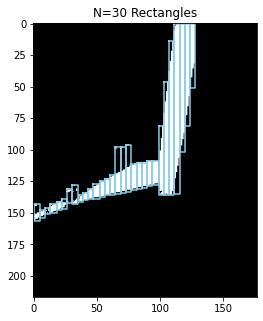

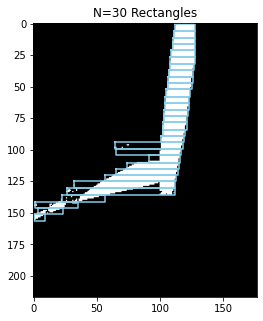

In [19]:
draw_rectangles(chull2, N=30, orientation='vertical', plot=True)
draw_rectangles(chull2, N=30, orientation='horizontal', plot=True)

Text(0.5, 1.0, 'Percent land area as number of rectangles increases')

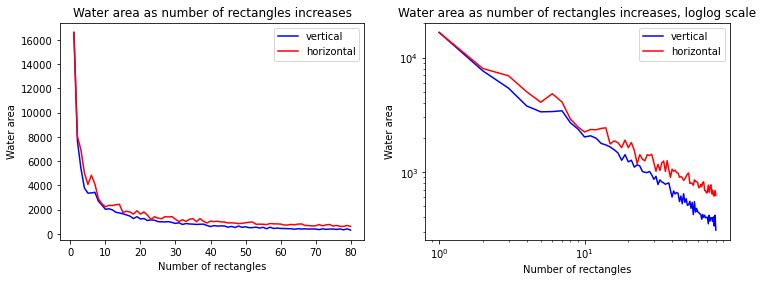

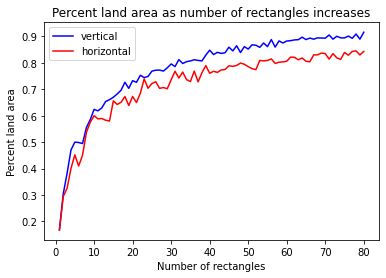

In [20]:
# plot water area as N increases for vertical and horizontal rectangles
N_arr = range(1, 81)
vwater_arr = []
hwater_arr = []

vland_arr = []
hland_arr = []

for N in N_arr:
    vtotal_area, vtotal_water = draw_rectangles(chull2, N, orientation='vertical', plot=False)
    vwater_arr.append(vtotal_water)
    vland_arr.append((vtotal_area - vtotal_water) / vtotal_area)
    
    htotal_area, htotal_water = draw_rectangles(chull2, N, orientation='horizontal', plot=False)
    hwater_arr.append(htotal_water)
    hland_arr.append((htotal_area - htotal_water) / htotal_area)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(N_arr, vwater_arr, 'b', label='vertical')
ax[0].plot(N_arr, hwater_arr, 'r', label='horizontal')
ax[0].set_xlabel('Number of rectangles')
ax[0].set_ylabel('Water area')
ax[0].legend(loc='best')
ax[0].set_title('Water area as number of rectangles increases')

ax[1].loglog(N_arr, vwater_arr, 'b', label='vertical')
ax[1].loglog(N_arr, hwater_arr, 'r', label='horizontal')
ax[1].set_xlabel('Number of rectangles')
ax[1].set_ylabel('Water area')
ax[1].legend(loc='best')
ax[1].set_title('Water area as number of rectangles increases, loglog scale')

# plot percent land area
fig, ax = plt.subplots(1, 1)
ax.plot(N_arr, vland_arr, 'b', label='vertical')
ax.plot(N_arr, hland_arr, 'r', label='horizontal')
ax.set_xlabel('Number of rectangles')
ax.set_ylabel('Percent land area')
ax.legend(loc='best')
ax.set_title('Percent land area as number of rectangles increases')


# Hatteras, rotated 90º clockwise

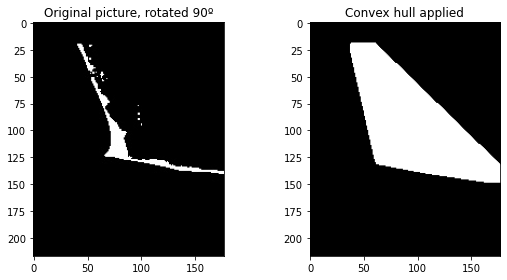

In [29]:
image90 = rotate(image, 270) # degrees counterclockwise

# draw separate convex hulls using cut points with n=10

image90_2 = np.copy(image90) # make copy of original image array

#print(np.shape(image))
#print(np.shape(image2))

n = 10
cut_point = cut_points(find_median_line(image90_2), n)
# extract x coordinate (corresponds to column of array)
cut_col = cut_point[0][0]

image90_2[:,cut_col:] = np.where(image90_2[:,cut_col:] > 0, 2, image90_2[:,cut_col:])

#print(image2[100:103])
#print(np.shape(image2))

#image2_labled = label(image2, connectivity=1)

chull90_2 = convex_hull_object(image90_2, connectivity=2) #SEE WHAT 1 DOES

# plot results
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].set_title('Original picture, rotated 90º')
ax[0].imshow(image90, cmap=plt.cm.gray)

ax[1].set_title('Convex hull applied')
ax[1].imshow(chull90_2, cmap=plt.cm.gray)

plt.tight_layout()
plt.show()

ValueError: not enough values to unpack (expected 2, got 0)

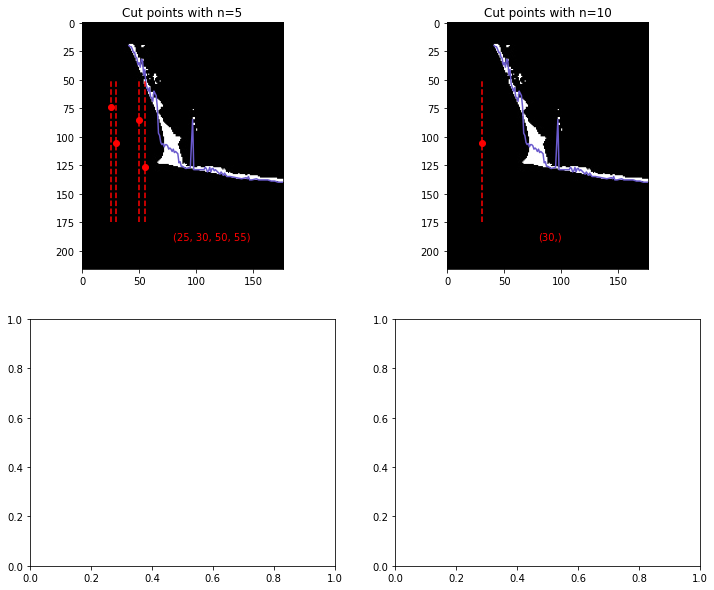

In [30]:
med_line90 = find_median_line(image90)

x, y = zip(*find_median_line(image90))
#cx, cy = zip(*find_median_line(chull))

fig, ax = plt.subplots(2, 2, figsize=(12,10))
ax = ax.ravel()

i = 0
for n in range(5, 25, 5):
    cut_x, cut_y = zip(*cut_points(med_line90, n))    
    
    ax[i].set_title('Cut points with n={}'.format(n))
    ax[i].imshow(image90, cmap=plt.cm.gray)
    ax[i].plot(x, y, 'slateblue')
    ax[i].plot(cut_x, cut_y, 'ro')
    ax[i].plot([cut_x, cut_x], [175, 50], 'r--')
    ax[i].annotate('{}'.format(cut_x), xy=(75, 180), xytext=(80, 190), color = 'red')
    
    i += 1
